# Team Offense Analysis

This notebook analyzes which attacking patterns work well **by** a specific team.

We will:
- Load and preprocess event data
- Filter for offense perspective (team acts as attacker)
- Compute zone success rates for passes/shots
- Visualize attacking patterns


In [93]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
from src.data_loader import load_raw_events, load_match_info
from src.feature_engineering import add_zone_columns, filter_team_vs_opponent
from src.analysis_utils import compute_zone_success_rate, compute_team_zone_profile

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Team name mapping (Korean -> English for plots)
TEAM_NAME_EN_MAP = {
    'FC서울': 'FC Seoul',
    '김천 상무 프로축구단': 'Gimcheon Sangmu FC',
    '울산 HD FC': 'Ulsan HD FC',
    '수원FC': 'Suwon FC',
    '포항 스틸러스': 'Pohang Steelers',
    '전북 현대 모터스': 'Jeonbuk Hyundai Motors',
    '제주SK FC': 'Jeju United FC',
    '강원FC': 'Gangwon FC',
    '대구FC': 'Daegu FC',
    '인천 유나이티드': 'Incheon United',
    '광주FC': 'Gwangju FC',
    '대전 하나 시티즌': 'Daejeon Hana Citizen'
}

def get_team_name_en(team_name_ko):
    """Convert Korean team name to English for plots."""
    return TEAM_NAME_EN_MAP.get(team_name_ko, team_name_ko)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration


In [94]:
# TODO: Adapt to real team names/IDs from the dataset
# Example: TARGET_TEAM = "울산 HD FC" or TARGET_TEAM = 2354
TARGET_TEAM = "울산 HD FC"  # Update with actual team identifier
# ['FC서울', '강원FC', '광주FC', '김천 상무 프로축구단', '대구FC', '대전 하나 시티즌', '수원FC', '울산 HD FC', '인천 유나이티드', '전북 현대 모터스', '제주SK FC', '포항 스틸러스']

# Perspective: offense (team acts as attacker)
AS_DEFENDER = False


## Data Loading & Preprocessing


In [95]:
# Load raw data
events = load_raw_events()
match_info = load_match_info()

print(f"Total events: {len(events)}")
print(f"Total matches: {len(match_info)}")

# Check available teams
print("\n" + "="*50)
print("Available teams in events:")
print(events['team_name_ko'].value_counts().head(20))
print("\n" + "="*50)
print("Available teams in match_info:")
all_teams = pd.concat([match_info['home_team_name_ko'], match_info['away_team_name_ko']]).unique()
print(sorted(all_teams))


Total events: 579306
Total matches: 198

Available teams in events:
team_name_ko
울산 HD FC       53492
광주FC           51701
FC서울           50233
포항 스틸러스        49779
수원FC           49075
강원FC           48150
인천 유나이티드       48136
김천 상무 프로축구단    47714
전북 현대 모터스      47032
제주SK FC        45551
대전 하나 시티즌      45131
대구FC           43312
Name: count, dtype: int64

Available teams in match_info:
['FC서울', '강원FC', '광주FC', '김천 상무 프로축구단', '대구FC', '대전 하나 시티즌', '수원FC', '울산 HD FC', '인천 유나이티드', '전북 현대 모터스', '제주SK FC', '포항 스틸러스']


In [96]:
# Add zone columns
# TODO: Adjust column names to match actual dataset
events = add_zone_columns(
    events,
    x_col="start_x",  # TODO: Adapt
    y_col="start_y",  # TODO: Adapt
)

print("Zones added. Sample:")
print(events[["zone", "start_x", "start_y"]].head())


Zones added. Sample:
   zone    start_x    start_y
0  AM-C  52.670205  34.919632
1  AM-C  68.628945  34.347412
2  AM-C  68.228055  33.853256
3  AM-C  65.468865  26.640292
4  AM-C  64.838025  26.766636


In [97]:
# Filter for offense perspective (team acts as attacker)
# TODO: Adjust column names and team identifier
offense_events = filter_team_vs_opponent(
    events,
    team_col="team_id",  # TODO: Adapt
    target_team=TARGET_TEAM,
    as_defender=AS_DEFENDER,
    match_info=match_info,
)

print(f"Offense events for {TARGET_TEAM}: {len(offense_events)}")
print(f"Percentage of total events: {len(offense_events) / len(events) * 100:.2f}%")


Offense events for 울산 HD FC: 53492
Percentage of total events: 9.23%


## Offense Metrics


In [98]:
# Compute zone success rate for passes and shots
# TODO: Adjust event type names to match actual dataset
success_by_zone = compute_zone_success_rate(
    offense_events,
    event_type_col="type_name",  # TODO: Adapt
    outcome_col="result_name",   # TODO: Adapt
)

# Filter for key event types
key_events = ["Pass", "Shot"]  # TODO: Adapt to actual event type names
success_filtered = success_by_zone[success_by_zone["event_type"].isin(key_events)]

print("Success Rate by Zone and Event Type:")
print(success_filtered.sort_values("success_rate", ascending=False))


Success Rate by Zone and Event Type:
       zone event_type  attempts  success  success_rate
338   nan-L       Pass         1        1      1.000000
102    AM-C       Pass      1977     1829      0.925139
268    DM-C       Pass      1911     1749      0.915228
124    AM-L       Pass      2228     1980      0.888689
313    DM-R       Pass      2354     2069      0.878929
290    DM-L       Pass      2114     1855      0.877483
147    AM-R       Pass      2164     1893      0.874769
239     D-R       Pass       688      583      0.847384
22      A-C       Pass       763      644      0.844037
187     D-C       Pass       845      708      0.837870
48      A-L       Pass       707      591      0.835926
213     D-L       Pass       678      565      0.833333
160  AM-nan       Pass        12       10      0.833333
74      A-R       Pass       806      661      0.820099
252   D-nan       Pass         7        5      0.714286
326  DM-nan       Pass        13        8      0.615385
86    A-nan

In [99]:
## Visualizations


### 1. Zone별 성공률 막대 그래프


C:\Users\hyoju\AppData\Local\Temp\ipykernel_33464\36326010.py:25: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Local\Temp\ipykernel_33464\36326010.py:25: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\hyoju\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hyoju\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


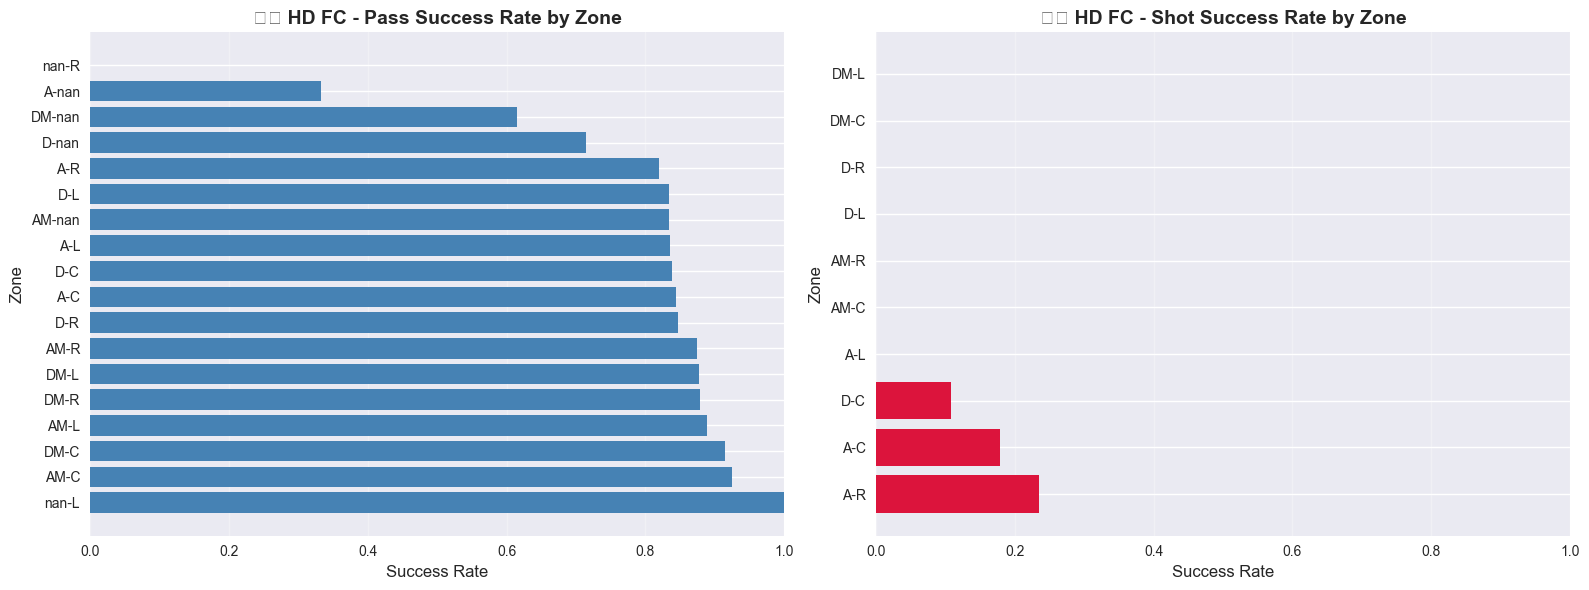

In [ ]:
# Bar chart of success rates by zone
if len(success_filtered) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pass success rate
    pass_data = success_filtered[success_filtered['event_type'] == 'Pass'].sort_values('success_rate', ascending=False)
    if len(pass_data) > 0:
        axes[0].barh(pass_data['zone'], pass_data['success_rate'], color='steelblue')
        axes[0].set_xlabel('Success Rate', fontsize=12)
        axes[0].set_ylabel('Zone', fontsize=12)
        axes[0].set_title(f'{get_team_name_en(TARGET_TEAM)} - Pass Success Rate by Zone', fontsize=14, fontweight='bold')
        axes[0].set_xlim(0, 1)
        axes[0].grid(axis='x', alpha=0.3)
    
    # Shot success rate
    shot_data = success_filtered[success_filtered['event_type'] == 'Shot'].sort_values('success_rate', ascending=False)
    if len(shot_data) > 0:
        axes[1].barh(shot_data['zone'], shot_data['success_rate'], color='crimson')
        axes[1].set_xlabel('Success Rate', fontsize=12)
        axes[1].set_ylabel('Zone', fontsize=12)
        axes[1].set_title(f'{get_team_name_en(TARGET_TEAM)} - Shot Success Rate by Zone', fontsize=14, fontweight='bold')
        axes[1].set_xlim(0, 1)
        axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization. Check if offense_events has data.")


### 2. Zone별 이벤트 분포 히트맵


Error creating heatmap: Unknown format code 'd' for object of type 'float'
zone_event_counts shape: (28, 3)
zone_event_counts head:
  zone type_name  event_count
0  A-C      Pass          763
1  A-C      Shot          162
2  A-L      Pass          707
3  A-L      Shot           23
4  A-R      Pass          806


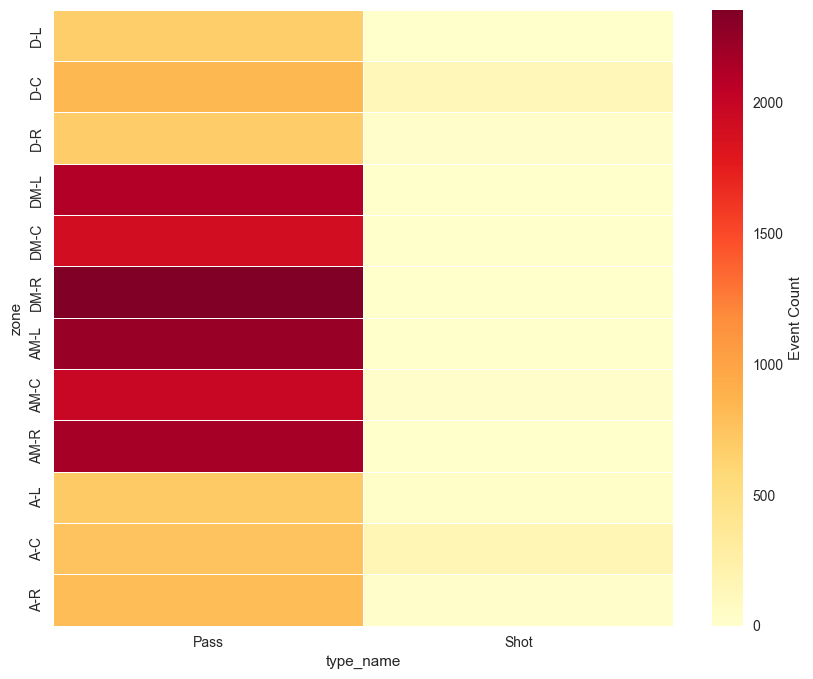

In [ ]:
# Heatmap of event distribution by zone
if len(offense_events) > 0:
    # Filter for key events
    key_events = offense_events[offense_events['type_name'].isin(['Pass', 'Shot'])].copy()
    
    if len(key_events) > 0:
        # Remove rows with NaN zone
        key_events_clean = key_events[key_events['zone'].notna()].copy()
        
        if len(key_events_clean) > 0:
            # Group by zone and event_type
            zone_event_counts = key_events_clean.groupby(['zone', 'type_name'], observed=True).size().reset_index(name='event_count')
            
            # Create pivot table for heatmap
            try:
                zone_pivot = zone_event_counts.pivot_table(
                    values='event_count',
                    index='zone',
                    columns='type_name',
                    fill_value=0
                )
                
                # Sort zones in a logical order (D, DM, AM, A for x-axis, L, C, R for y-axis)
                zone_order = ['D-L', 'D-C', 'D-R', 'DM-L', 'DM-C', 'DM-R', 'AM-L', 'AM-C', 'AM-R', 'A-L', 'A-C', 'A-R']
                # Keep only zones that exist in the data
                existing_zones = [z for z in zone_order if z in zone_pivot.index]
                if existing_zones:
                    zone_pivot = zone_pivot.reindex(existing_zones)
                
                if len(zone_pivot) > 0 and len(zone_pivot.columns) > 0:
                    fig, ax = plt.subplots(figsize=(10, 8))
                    sns.heatmap(zone_pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax, 
                               cbar_kws={'label': 'Event Count'}, linewidths=0.5)
                    ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Event Distribution by Zone', fontsize=14, fontweight='bold')
                    ax.set_xlabel('Event Type', fontsize=12)
                    ax.set_ylabel('Zone', fontsize=12)
                    plt.tight_layout()
                    plt.show()
                else:
                    print("Pivot table is empty after processing.")
            except Exception as e:
                print(f"Error creating heatmap: {e}")
                print(f"zone_event_counts shape: {zone_event_counts.shape}")
                print(f"zone_event_counts head:\n{zone_event_counts.head()}")
        else:
            print("No events with valid zones found.")
    else:
        print("No key events (Pass, Shot) found.")
else:
    print("No offense events available.")


### 3. 패스 맵 시각화


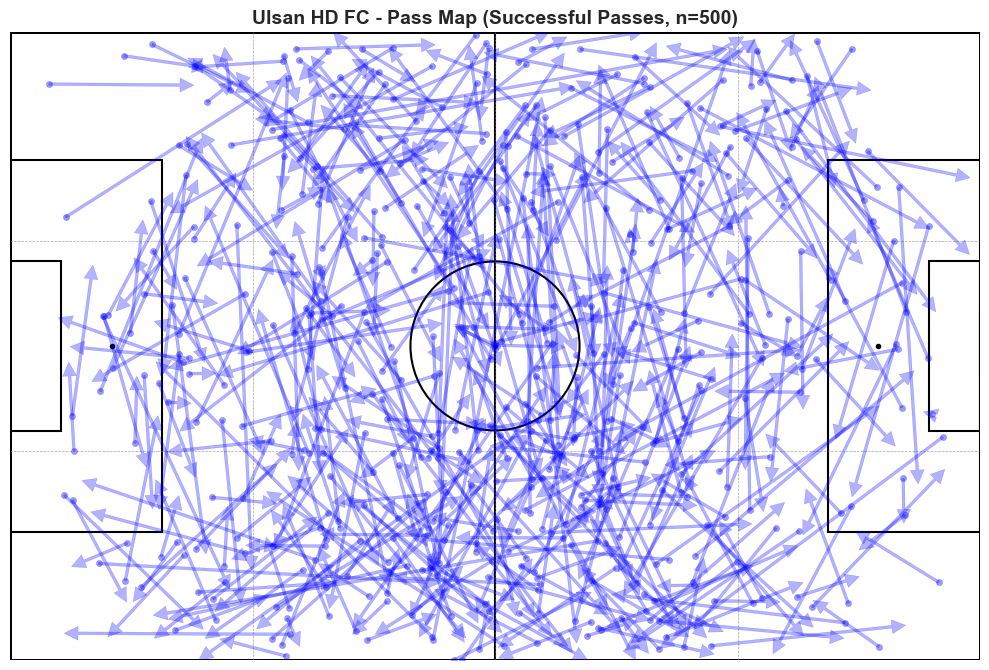

In [102]:
# Pass map visualization with start positions
if len(offense_events) > 0:
    from src.pitch_plot import draw_pitch, plot_pass_arrows, plot_events_scatter, add_zones_to_ax
    
    # Filter for successful passes only
    passes = offense_events[
        (offense_events['type_name'] == 'Pass') & 
        (offense_events['result_name'] == 'Successful')
    ].copy()
    
    if len(passes) > 0:
        # Sample passes if too many (for performance)
        sample_size = min(500, len(passes))
        passes_sample = passes.sample(n=sample_size, random_state=42) if len(passes) > sample_size else passes
        
        # Remove NaN coordinates
        passes_sample = passes_sample[
            passes_sample['start_x'].notna() & 
            passes_sample['start_y'].notna() &
            passes_sample['end_x'].notna() & 
            passes_sample['end_y'].notna()
        ].copy()
        
        if len(passes_sample) > 0:
            fig, ax = plt.subplots(figsize=(10, 14))
            draw_pitch(ax=ax, show=False)
            add_zones_to_ax(ax)
            
            # Ensure axes limits are set correctly
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            # Plot pass start positions as dots
            ax.scatter(
                passes_sample['start_x'],
                passes_sample['start_y'],
                c='blue',
                alpha=0.4,
                s=20,
                zorder=2
            )
            
            # Plot pass arrows
            ax = plot_pass_arrows(
                passes_sample,
                ax=ax,
                x_start_col="start_x",
                y_start_col="start_y",
                x_end_col="end_x",
                y_end_col="end_y",
                color="blue",
                alpha=0.3,
                arrow_width=0.3,
                head_width=1.5,
                head_length=1.5,
                draw_pitch_flag=False,
                max_arrows=500,
            )
            
            # Ensure axes limits again after plotting
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Pass Map (Successful Passes, n={len(passes_sample)})', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("No passes with valid coordinates found.")
    else:
        print("No successful passes found.")
else:
    print("No offense events available.")


### 4. 슛 위치 플롯


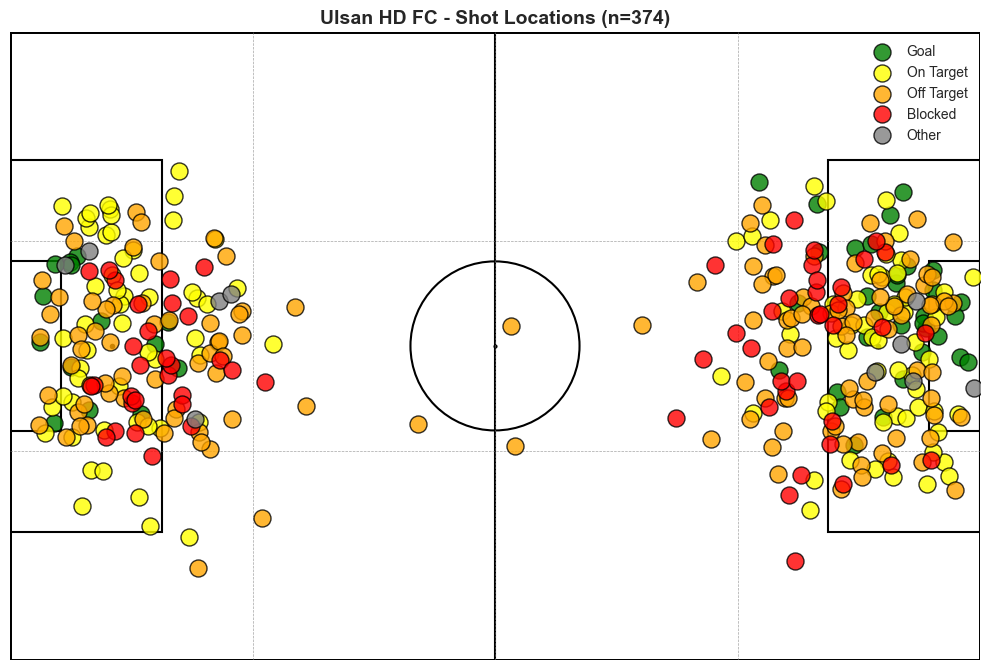


Shot Statistics for 울산 HD FC:
shot_result
Off Target    141
On Target     112
Blocked        64
Goal           47
Other          10
Name: count, dtype: int64

Goal Rate: 12.57%


In [103]:
# Shot location plot on pitch
if len(offense_events) > 0:
    from src.pitch_plot import draw_pitch, plot_events_scatter, add_zones_to_ax
    
    # Filter for shots
    shots = offense_events[offense_events['type_name'] == 'Shot'].copy()
    
    if len(shots) > 0:
        # Create result category for coloring
        shots['shot_result'] = shots['result_name'].fillna('Other')
        # Keep Goal, On Target, Off Target, Blocked as is, others as 'Other'
        shots.loc[~shots['shot_result'].isin(['Goal', 'On Target', 'Off Target', 'Blocked']), 'shot_result'] = 'Other'
        
        # Create color mapping
        result_colors = {
            'Goal': 'green',
            'On Target': 'yellow',
            'Off Target': 'orange',
            'Blocked': 'red',
            'Other': 'gray'
        }
        shots['shot_color'] = shots['shot_result'].map(result_colors)
        
        # Remove NaN coordinates
        shots_clean = shots[
            shots['start_x'].notna() & 
            shots['start_y'].notna()
        ].copy()
        
        if len(shots_clean) > 0:
            fig, ax = plt.subplots(figsize=(10, 14))
            draw_pitch(ax=ax, show=False)
            add_zones_to_ax(ax)
            
            # Ensure axes limits are set correctly
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            # Plot shots colored by result - plot each category separately for better legend
            for result, color in result_colors.items():
                shots_result = shots_clean[shots_clean['shot_result'] == result]
                if len(shots_result) > 0:
                    ax.scatter(
                        shots_result['start_x'],
                        shots_result['start_y'],
                        c=color,
                        s=150,
                        alpha=0.8,
                        edgecolors='black',
                        linewidths=1,
                        label=result,
                        zorder=5
                    )
            
            # Ensure axes limits again after plotting
            ax.set_xlim(0, 105)
            ax.set_ylim(0, 68)
            
            # Add legend
            ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
            
            ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Shot Locations (n={len(shots_clean)})', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("No shots with valid coordinates found.")
        
        # Print shot statistics
        print(f"\nShot Statistics for {TARGET_TEAM}:")
        print(shots['shot_result'].value_counts())
        if 'Goal' in shots['shot_result'].values:
            goal_rate = len(shots[shots['shot_result'] == 'Goal']) / len(shots) * 100
            print(f"\nGoal Rate: {goal_rate:.2f}%")
    else:
        print("No shots found.")
else:
    print("No offense events available.")


### 5. Zone별 이벤트 밀도 히트맵 (피치 위)


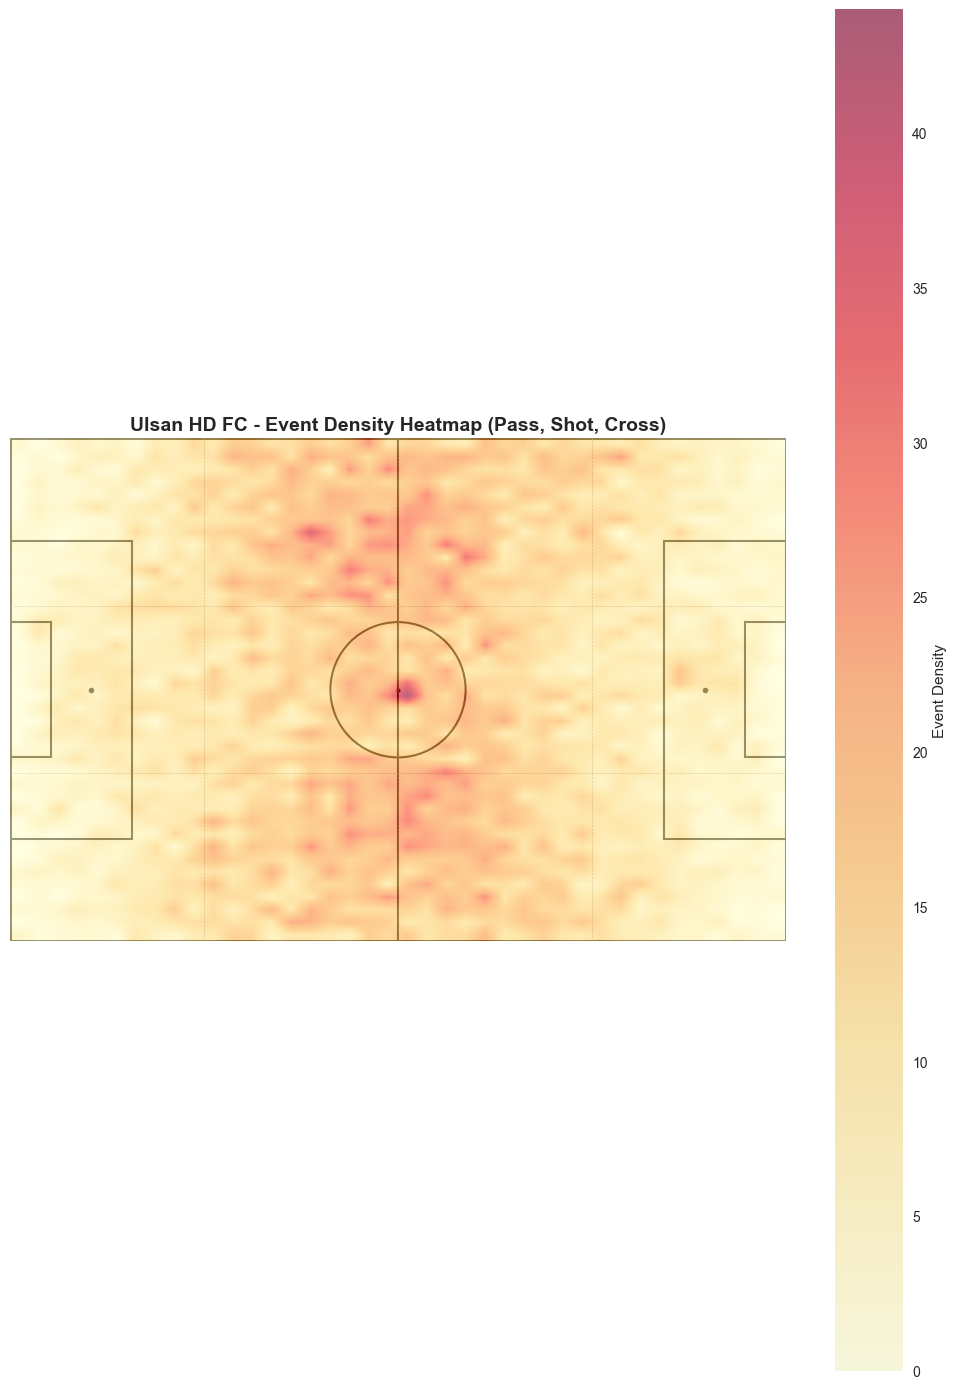

Total events in heatmap: 18215


In [104]:
# Event density heatmap on pitch
if len(offense_events) > 0:
    from src.pitch_plot import draw_pitch, simple_kde_heatmap, add_zones_to_ax
    
    # Filter for key events
    key_events = offense_events[offense_events['type_name'].isin(['Pass', 'Shot', 'Cross'])].copy()
    
    # Remove NaN coordinates
    key_events_clean = key_events[
        key_events['start_x'].notna() & 
        key_events['start_y'].notna()
    ].copy()
    
    if len(key_events_clean) > 0:
        fig, ax = plt.subplots(figsize=(10, 14))
        draw_pitch(ax=ax, show=False)
        add_zones_to_ax(ax)
        
        # Ensure axes limits are set correctly
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        # Plot heatmap with better visibility
        ax = simple_kde_heatmap(
            key_events_clean,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            bins=40,
            cmap="YlOrRd",  # Yellow-Orange-Red for better visibility
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        
        # Ensure axes limits again after plotting
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Event Density Heatmap (Pass, Shot, Cross)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"Total events in heatmap: {len(key_events_clean)}")
    else:
        print("No key events with valid coordinates found for heatmap.")
else:
    print("No offense events available.")


### 6. 패스 시작 위치 히트맵


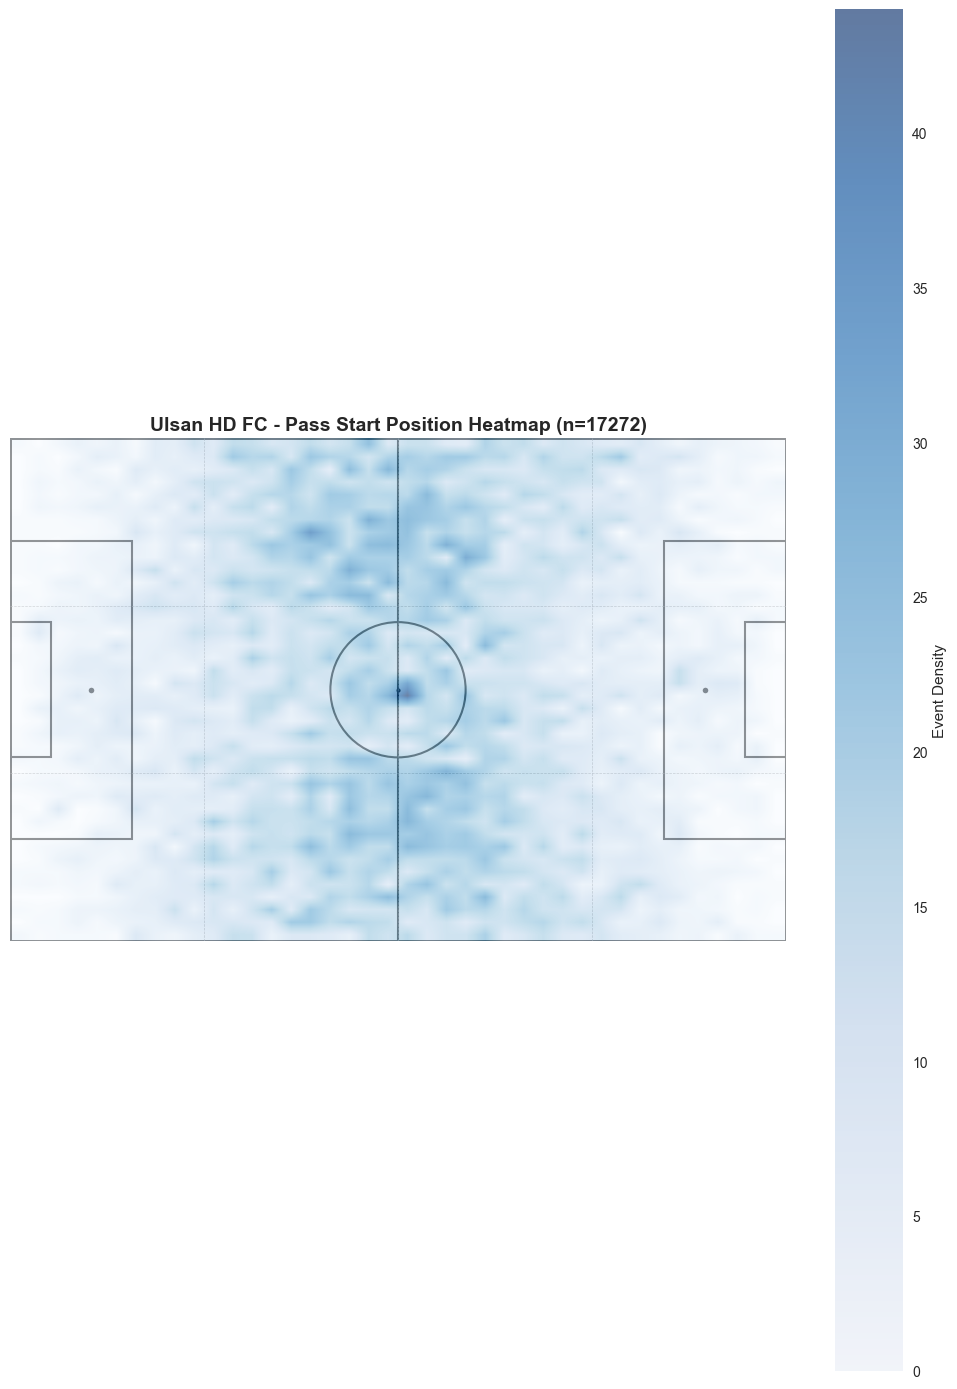

In [105]:
# Pass start position heatmap on pitch
if len(offense_events) > 0:
    from src.pitch_plot import draw_pitch, simple_kde_heatmap, add_zones_to_ax
    
    # Filter for passes
    passes = offense_events[offense_events['type_name'] == 'Pass'].copy()
    
    # Remove NaN coordinates
    passes_clean = passes[
        passes['start_x'].notna() & 
        passes['start_y'].notna()
    ].copy()
    
    if len(passes_clean) > 0:
        fig, ax = plt.subplots(figsize=(10, 14))
        draw_pitch(ax=ax, show=False)
        add_zones_to_ax(ax)
        
        # Ensure axes limits are set correctly
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        # Plot heatmap
        ax = simple_kde_heatmap(
            passes_clean,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            bins=40,
            cmap="Blues",
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        
        # Ensure axes limits again after plotting
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Pass Start Position Heatmap (n={len(passes_clean)})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("No passes with valid coordinates found.")
else:
    print("No offense events available.")


### 7. 슛 위치 히트맵


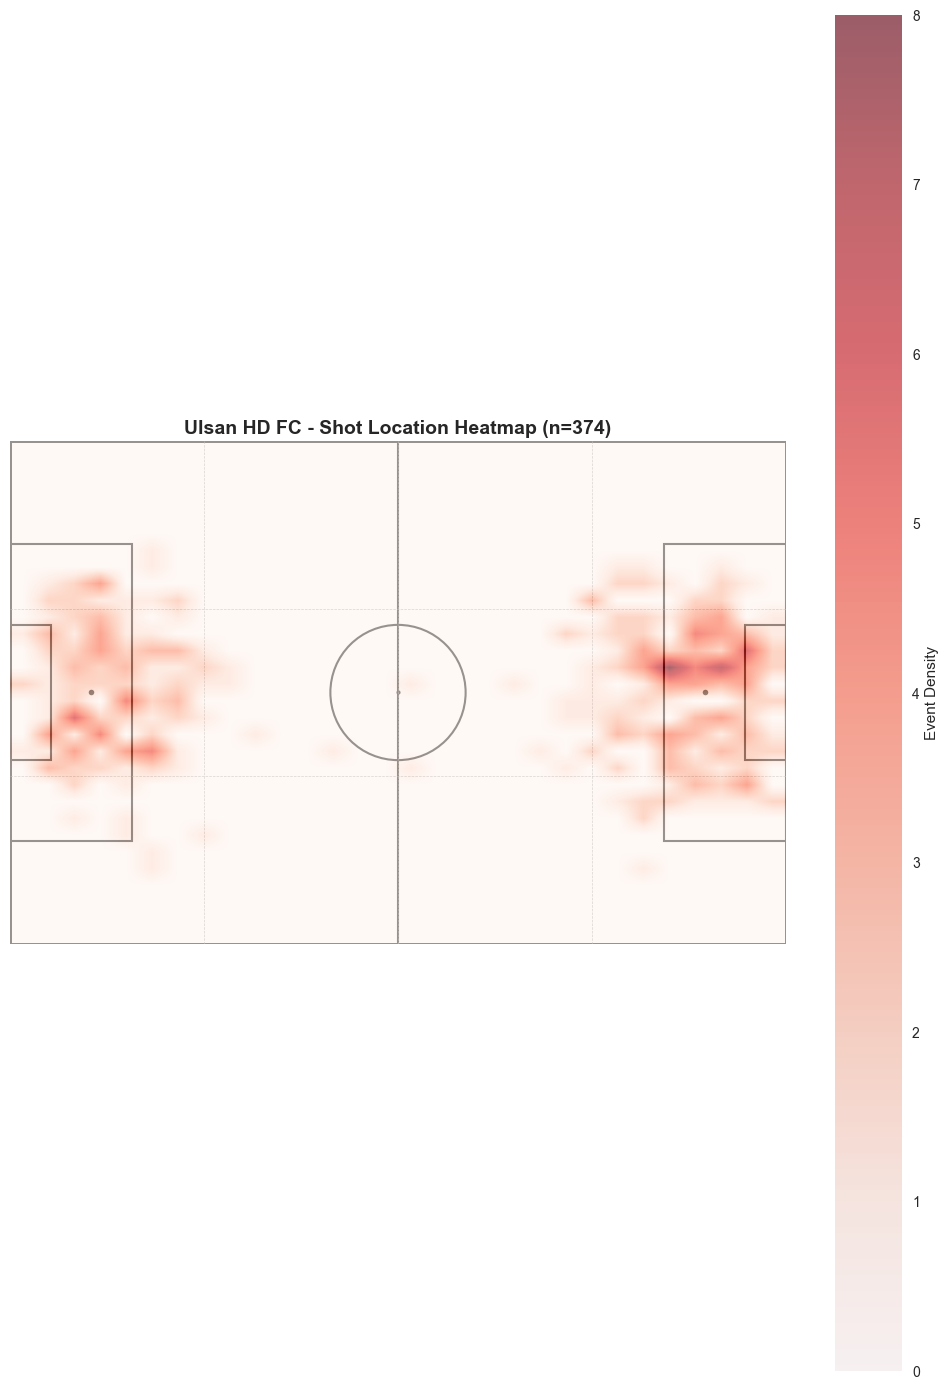

In [106]:
# Shot location heatmap on pitch
if len(offense_events) > 0:
    from src.pitch_plot import draw_pitch, simple_kde_heatmap, add_zones_to_ax
    
    # Filter for shots
    shots = offense_events[offense_events['type_name'] == 'Shot'].copy()
    
    # Remove NaN coordinates
    shots_clean = shots[
        shots['start_x'].notna() & 
        shots['start_y'].notna()
    ].copy()
    
    if len(shots_clean) > 0:
        fig, ax = plt.subplots(figsize=(10, 14))
        draw_pitch(ax=ax, show=False)
        add_zones_to_ax(ax)
        
        # Ensure axes limits are set correctly
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        # Plot heatmap
        ax = simple_kde_heatmap(
            shots_clean,
            ax=ax,
            x_col="start_x",
            y_col="start_y",
            bins=30,
            cmap="Reds",
            draw_pitch_flag=False,
            show_colorbar=True,
        )
        
        # Ensure axes limits again after plotting
        ax.set_xlim(0, 105)
        ax.set_ylim(0, 68)
        
        ax.set_title(f'{get_team_name_en(TARGET_TEAM)} - Shot Location Heatmap (n={len(shots_clean)})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("No shots with valid coordinates found.")
else:
    print("No offense events available.")
